# Predict Insurance Claim Denial

- We are interested in an analytic and/or predictive model to predict claims that would be denied with the following Denial.Reason.Code: F13, J8G, JO5, JB8, JE1, JC9, JF1, JF9, JG1, JPA and JES.
- Feel free to use any language (e.g. R, Python). Please send us the code and a brief write up of your findings (e.g. on the sensitivity and specificity of the algorithm).

# Structure of the report

- this report is divided into feature engineering, training and parameter optimization for fine tuning the trade-off precision/recall
- we include comments and conclusion with the code

# Import pandas, sklearn, numpy and matplotlib

- we use standard libraries sklearn for machine learning and pandas for data processing

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import sem
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import svm
from sklearn import naive_bayes
from sklearn import ensemble
from sklearn import neighbors
from sklearn import metrics
from sklearn import learning_curve
from sklearn import cross_validation
from sklearn import grid_search
from sklearn import kernel_approximation
from sklearn import feature_selection
from sklearn import decomposition
from scipy.stats import randint as sp_randint
import mca
from IPython import embed
import seaborn
%matplotlib inline 

# Helper functions

- these helper functions are used to visualize data and plot error curves

In [4]:
# HELPER FUNCTION DEFINITIONS
    
def confusion_matrix(y_true, y_pred):
  confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
  plt.matshow(confusion_matrix)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.colorbar()
  plt.show()


def roc_curve(model, X_test, y_test):
  preds_proba = model.predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = metrics.roc_curve(y_test, preds_proba)
  roc_auc = metrics.auc(fpr, tpr)
  plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
  plt.plot(fpr, tpr, 'k--', label='ROC (area = %0.2f)' % roc_auc, lw=2)
  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xlabel('False Positive Rate=1-specificity')
  plt.ylabel('True Positive Rate/Recall/Sensitivity')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")


def precision_recall_curve(model, X_test, y_test):
  score = model.decision_function(X_test)
  precision, recall, _ = metrics.precision_recall_curve(y_test, score)
  plt.plot(recall, precision, label='Precision-Recall curve')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Recall/Sensitivity')
  plt.ylabel('Precision')
  plt.title('Precision-Recall curve')
  plt.legend(loc="lower right")


def learning_curves(X_train, y_train, model, scoring='accuracy', cv=5):
  plt.figure()
  plt.title("Learning curve")
  plt.xlabel("Number of training examples")
  plt.ylabel("scores")
  train_sizes, train_scores, test_scores = learning_curve.learning_curve(model, X_train, y_train, scoring=scoring, cv=cv, verbose=1)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="r")
  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
  plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="g")
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
  plt.legend(loc="best")
  plt.autoscale(tight=True)
  plt.show()

    
def model_selection(X_train, X_test, y_train, y_test, parameters, clf, scoring=None, cv=3):
  clf_grid = grid_search.RandomizedSearchCV(clf, parameters, verbose=1, scoring=scoring, cv=cv, n_jobs=-1)
  # clf_grid = grid_search.GridSearch(clf, parameters, verbose=1, scoring=scoring, cv=cv, n_jobs=-1)
  clf_grid.fit(X_train, y_train)
  print "------------------------------------------------------------------------"
  print "best parameters:"
  print clf_grid.best_params_
  print "best score:"
  print clf_grid.best_score_
  print "------------------------------------------------------------------------"
  print("Best parameters set found on cross-validation set:")
  print(clf_grid.best_estimator_)
  print "------------------------------------------------------------------------"
  print("Grid scores on CV set:")
  for params, mean_score, scores in clf_grid.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() / 2, params))
  print "------------------------------------------------------------------------"
  print("Classification report on test set:")
  y_true, y_pred = y_test, clf_grid.predict(X_test)
  print(metrics.classification_report(y_true, y_pred))
  return clf_grid


def feature_importance(model, top=25):
  feature_importance = model.feature_importances_
  # Normalize The Features
  feature_importance = 100.0 * (feature_importance / feature_importance.max())
  sorted_idx = np.argsort(feature_importance)
  pos = np.arange(sorted_idx.shape[0]) + .5
  # plt.figure(figsize=(16, 12))
  plt.barh(pos[-top:], feature_importance[sorted_idx[-top:]], align='center', color='#7A68A6')
  # plt.yticks(pos, np.asanyarray(df.columns.tolist())[sorted_idx])
  plt.yticks(pos[-top:], sorted_idx[-top:])
  plt.xlabel('Relative Importance')
  plt.ylabel('Feature Column Number')
  plt.title('Feature Importance')
  plt.show()

# Data import and transform

- Replace empty cells by NaN code, drop duplicates and keep only rows with actual denial code

In [5]:
# READ DATA replace empty cells by nan
df = pd.read_csv("claim.sample.csv", index_col=0, na_values=[" "], low_memory=False)

In [6]:
df = df.drop_duplicates()
# keep only rows where we actually have a denial code
df = df[df['Denial.Reason.Code'].notnull()]
df.shape

(146529, 28)

- 146529 total cases left and 28 features

# Feature Engineering

- we separate features by type
- encode categorical features with type "category"
- code denial reason code into binary variable YES (denied) and NO (approved)
- check the number of categories for each category/feature

In [7]:
# Separate Features by type
categorical = [
    u'Claim.Line.Number', u'Provider.ID',
    u'Line.Of.Business.ID', u'Revenue.Code', u'Service.Code',
    u'Place.Of.Service.Code',
    u'Price.Index',
    u'In.Out.Of.Network', u'Reference.Index', u'Pricing.Index',
    u'Capitation.Index',
    u'Claim.Type', u'Claim.Subscriber.Type',
    u'Claim.Pre.Prince.Index', u'Claim.Current.Status', u'Network.ID',
    u'Agreement.ID']
indices = [u'Claim.Number', u'Group.Index', u'Subscriber.Index', u'Subgroup.Index']
continuous = [u'Claim.Charge.Amount', u'Subscriber.Payment.Amount', u'Provider.Payment.Amount']
medical_idx = [u'Procedure.Code', u'Diagnosis.Code']
denial = [u'Denial.Reason.Code']
user_id = [u'Member.ID']

len(categorical)+len(indices)+len(continuous)+len(medical_idx)+len(denial)+len(user_id)

28

In [8]:
# encode features into factor variables and check number of category per feature
for col in df[categorical]:
    df[col] = df[col].astype('category')
    print "---- "+ col
    print df[col].describe()

for col in df[medical_idx]:
    df[col] = df[col].astype('category')
    print "---- "+ col
    print df[col].describe()

for col in df[denial]:
    df[col] = df[col].astype('category')

for col in df[indices]:
    df[col] = df[col].astype('category')
    print "---- "+ col
    print df[col].describe()

df['Member.ID'] = df['Member.ID'].astype('category')
print "---- Member.ID"
df['Member.ID'].describe()

---- Claim.Line.Number
count     146529
unique       135
top            1
freq       30477
Name: Claim.Line.Number, dtype: int64
---- Provider.ID
count           146529
unique              26
top       FA0001411001
freq             42856
Name: Provider.ID, dtype: object
---- Line.Of.Business.ID
count     144700
unique         5
top            1
freq       72859
Name: Line.Of.Business.ID, dtype: float64
---- Revenue.Code
count     146473
unique       160
top         0301
freq       16764
Name: Revenue.Code, dtype: object
---- Service.Code
count     146529
unique       112
top         LA7O
freq       32571
Name: Service.Code, dtype: object
---- Place.Of.Service.Code
count     56
unique     2
top       11
freq      43
Name: Place.Of.Service.Code, dtype: float64
---- Price.Index
count     127502
unique         2
top            A
freq      124635
Name: Price.Index, dtype: object
---- In.Out.Of.Network
count     143781
unique         2
top            I
freq      141717
Name: In.Out.Of.Networ

count       146529
unique       11799
top       21880031
freq           750
Name: Member.ID, dtype: int64

In [9]:
# transform denial target codes to binary
denial = ["F13", "J8G", "JO5", "JB8", "JE1", "JC9", "JF1", "JF9", "JG1", "JPA", "JES"]
target = []
for row in df['Denial.Reason.Code']:
    if row in denial:
        target.append('YES')
    else:
        target.append('NO')
df['target'] = target

# Descriptive Analysis

- A pie plot of the data shows that the dataset is highly unbalanced with only **1.3% of denial** which makes sense

NO     144558
YES      1971
Name: target, dtype: int64
% of denial:  0.0134512622075


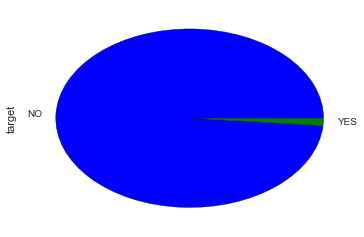

In [10]:
print df['target'].value_counts()
df['target'].value_counts().plot(kind='pie')
print "% of denial: ", 1971./(1971+144558)

# Multicollinearity

- by computing cross-tabs we can see how the distribution of categories impact the outcome
- we want to look at colinearity of categorical variables. one way to do this is multiple correspondence analysis (~ PCA for categorical variables)
- the computation seems to take a long time on my laptop, so didn't I didn't do a thorough analysis here
- keeping all the features for now. would do a more detailed feature selection analysis with more time at hand

In [11]:
#X = df[categorical+indices+medical_idx+user_id]
X = df[medical_idx]
X.head()
# look at distribution of YES/NO depending on categorical features
for label in categorical:
    print pd.crosstab(df[label],df['target'])

# takes too much computation...
# X_dum = pd.get_dummies(X)
# X_dum.head()
#mca_ben = mca.mca(X_dum)

target                NO  YES
Claim.Line.Number            
1                  30372  105
2                  18021  106
3                  11212  138
4                   9209  182
5                   7898  178
6                   6766  168
7                   6017  163
8                   5356  114
9                   4738   93
10                  4235   72
11                  3771   58
12                  3342   50
13                  2942   47
14                  2609   27
15                  2306   28
16                  2056   23
17                  1827   22
18                  1634   19
19                  1515   20
20                  1339   20
21                  1217   23
22                  1103   15
23                  1011   14
24                   935   15
25                   873   15
26                   798   15
27                   733   10
28                   675    9
29                   642   12
30                   594   10
...                  ...  ...
106       

# Correlation of Continuous Features

- The continuous features claim.charge.amount and provider.payment.amount are correlated (r~0.54), which makes sense
- when trying to predict target only from continuous variables, results were poor. so we decide to look at categorical features for prediction

                           Claim.Charge.Amount  Subscriber.Payment.Amount  \
Claim.Charge.Amount                   1.000000                   0.006007   
Subscriber.Payment.Amount             0.006007                   1.000000   
Provider.Payment.Amount               0.536622                   0.001362   

                           Provider.Payment.Amount  
Claim.Charge.Amount                       0.536622  
Subscriber.Payment.Amount                 0.001362  
Provider.Payment.Amount                   1.000000  


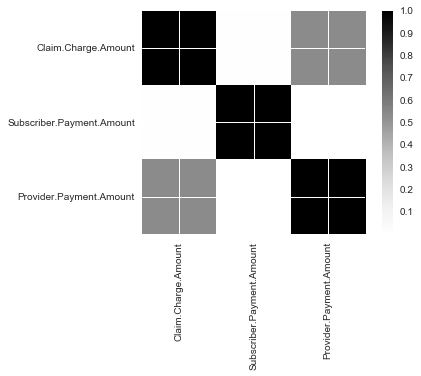

In [12]:
plt.imshow(abs(df[continuous].corr()) , interpolation='nearest')
ax = plt.axes()
plt.colorbar()
#ax.set_xticks(range(len(df.corr().columns)))
ax.set_xticks(range(len(df.columns)))
ax.set_xticklabels(df[continuous].columns, rotation=90)
ax.set_yticks(range(len(df.columns)))
ax.set_yticklabels(df[continuous].columns)
plt.plot()
print abs(df[continuous].corr())

# Percentage of null values in categorical features

- place.of.service.code feature has consistently 99% NaN accross classes so we could get rid of it
- price.index, capitation.index, claim.pre.prince.index have also >15% NaN

In [13]:
denials = df[df.target=='YES']
approvals = df[df.target=='NO']

In [14]:
X = denials[categorical]
print "---- denials"
print 1-(X.count()/X.shape[0])
X = approvals[categorical]
print "---- approvals"
print 1-(X.count()/X.shape[0])

---- denials
Claim.Line.Number         0.000000
Provider.ID               0.000000
Line.Of.Business.ID       0.000000
Revenue.Code              0.010147
Service.Code              0.000000
Place.Of.Service.Code     0.989853
Price.Index               0.257737
In.Out.Of.Network         0.000000
Reference.Index           0.000000
Pricing.Index             0.000000
Capitation.Index          0.174531
Claim.Type                0.000000
Claim.Subscriber.Type     0.000000
Claim.Pre.Prince.Index    0.825469
Claim.Current.Status      0.000000
Network.ID                0.021309
Agreement.ID              0.000000
dtype: float64
---- approvals
Claim.Line.Number         0.000000
Provider.ID               0.000000
Line.Of.Business.ID       0.012652
Revenue.Code              0.000249
Service.Code              0.000000
Place.Of.Service.Code     0.999751
Price.Index               0.128108
In.Out.Of.Network         0.019010
Reference.Index           0.000000
Pricing.Index             0.000000
Capitation.I

In [15]:
X = denials[medical_idx]
print "---- denials"
print 1-(X.count()/X.shape[0])
X = approvals[medical_idx]
print "---- approvals"
print 1-(X.count()/X.shape[0])

---- denials
Procedure.Code    0.335363
Diagnosis.Code    0.000000
dtype: float64
---- approvals
Procedure.Code    0.191563
Diagnosis.Code    0.000000
dtype: float64


# Encode features and target

- knowing nothing else about the features than their labels, we decide to encode them as categorical (and not ordinal, where we could just replace categories by ordered numbers)
- for this we use one hot encoding, which significantly increases the dimensionality of the feature space. We will make sure that we can generalize the classifier and won't overfit by using cross-validation.

In [16]:
#X = df[categorical+indices+medical_idx+user_id+continuous]
X = df[categorical+indices+medical_idx+user_id]
# X = df[categorical+medical_idx+user_id+continuous]
# X = df[categorical+medical_idx+continuous]
print X.shape

# Encode features
feature_le = preprocessing.LabelEncoder()
X = X.apply(feature_le.fit_transform)

ohe = preprocessing.OneHotEncoder()
ohe.fit(X)
X = ohe.transform(X)
print X.shape
# Encode binary target
target_le = preprocessing.LabelEncoder()
target_le.fit(df.target)
print target_le.classes_
y = target_le.transform(target)

(146529, 24)
(146529, 212751)
['NO' 'YES']


/usr/local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


# Split data into train and test sets

- we leave 20% of the data for testing and 80% for training

In [17]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=.20)

# Machine learning models

- we compared several standard classifiers and found that logistic regression and random forest tended to perform better
-  we use the option class_weight='balanced' to take into account the fact that our dataset is unbalanced

In [29]:
models = {}
models['lr'] = linear_model.LogisticRegression(n_jobs=-1, class_weight='balanced')
# models['pac'] = linear_model.PassiveAggressiveClassifier(n_jobs=-1)
# models['sgdc'] = linear_model.SGDClassifier(n_jobs=-1) #, class_weight='balanced')
# # models['ridge'] = linear_model.RidgeClassifier(class_weight='balanced')
# # models['svm'] = svm.SVC() # kernel='rbf', probability=True, class_weight='balanced')
# # models['nb'] = naive_bayes.GaussianNB()
# # models['gbc'] = ensemble.GradientBoostingClassifier()
models['rfc'] = ensemble.RandomForestClassifier(n_jobs=-1, class_weight='balanced')
# models['etc'] = ensemble.ExtraTreesClassifier(n_jobs=-1, class_weight='balanced')
# models['knc'] = neighbors.KNeighborsClassifier(n_jobs=-1)

# Cross validated metrics

- we want to make sure that our classifier can generalize and compute f1 scores on a 3 fold cross validation set
- we chose f1 because of our unbalanced data. we want to have a good tradeoff between precision and recall

In [30]:
for algo in models:
    model = models[algo]
    cv = cross_validation.StratifiedKFold(y_train, n_folds=3, shuffle=True)
    # scoring: 'accuracy, f1, recall, roc_auc'
    # scores = cross_validation.cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    scores = cross_validation.cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    print "---" + algo
    print scores.mean() # , sem(scores)

---rfc
0.658404077205
---lr
0.742292668676


# Classification report on test set

- ultimately we want to look at precision, recall and f1 on the test set
- we notice that precision is not as good as we could hope for
- for our use case it's probably more important to have good precision than good recall (we'd rather not wrongly deny a claim, at the price of allowing ourselves to miss a few claims that should be denied)

In [31]:
# When making predictions, retrain the model on the whole training set
for algo in models:
  print "----"+ algo
  model = models[algo]
  if algo == 'gbc':
    model.fit(X_train.todense(), y_train)
  else:
    model.fit(X_train, y_train)
  preds = model.predict(X_test)
  print metrics.classification_report(y_test, preds)

----rfc
             precision    recall  f1-score   support

          0       0.99      1.00      1.00     28929
          1       0.95      0.56      0.70       377

avg / total       0.99      0.99      0.99     29306

----lr
             precision    recall  f1-score   support

          0       1.00      0.99      1.00     28929
          1       0.68      0.92      0.78       377

avg / total       0.99      0.99      0.99     29306



- here we can see how the 2 classifiers have different behaviors random forest being better at precision and poor at recall and vice versa for logistic regression
- depending on our final objective we can choose to emphasize one versus the other
- here we choose to optimize logistic regression regularization parameter in order to increase precision

# Learning Curve

- learning curves allows to see if the model suffer from high variance or bias (e.g. does adding more sample improves the score?)
- we choose f1 score for learning curve as it expresses a combination of precision and recall
- precision/recall curve and roc_curve show how the binary classifier behaves

[learning_curve] Training set sizes: [ 7814 25398 42981 60564 78148]


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.2min finished


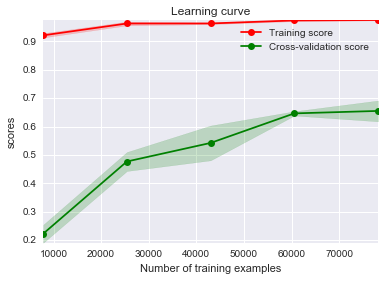

In [32]:
learning_curves(X_train, y_train, models['rfc'], scoring='f1', cv=3)

[learning_curve] Training set sizes: [ 7814 25398 42981 60564 78148]


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   22.1s finished


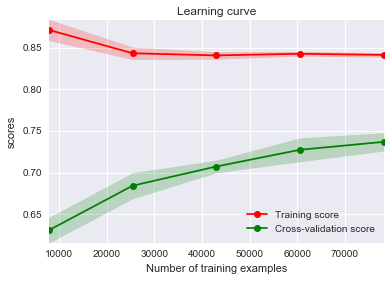

In [60]:
learning_curves(X_train, y_train, linear_model.LogisticRegression(n_jobs=-1, class_weight='balanced'), scoring='f1', cv=3)

- the cross-validation score curve for logistic regression increases with number of samples, which suggests that by adding more data we could improve our classifier
- there is a bias towards 0.85 for f1
- we will try to find the best regularization parameter for logistic regression to increase precision

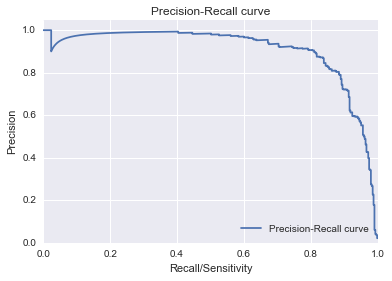

In [21]:
precision_recall_curve(models['lr'], X_test, y_test)

- the precision recall curve gives us an idea of the tradeoff we can hope for. it looks like ~0.85% for both precision and recall is achievable

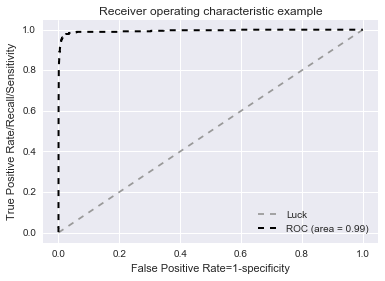

In [33]:
roc_curve(models['lr'], X_test, y_test)

# Feature selection

- recursive feature elimination on this dataset takes too long
- with more time (or more cores/computers) I would investigate more techniques

In [ ]:
# rfecv = feature_selection.RFECV(
#     estimator=models['lr'],
#     step=1, cv=cross_validation.StratifiedKFold(y_train, 2),
#     scoring='f1')
# rfecv.fit(X_train, y_train)
#rfe = feature_selection.RFE(estimator = models['lr'], step =10)
#rfe.fit(X_train, y_train)
model = linear_model.LogisticRegression(n_jobs=-1)
# fs = feature_selection.SelectKBest(feature_selection.f_classif, k=212700)
# fs = decomposition.TruncatedSVD(n_components=10000)
# X_train_reduced = fs.fit_transform(X_train, y_train)
# np.shape(X_train_reduced)
# X_test_reduced = fs.fit_transform(X_test, y_test)
# np.shape(X_test_reduced)
# model.fit(X_train_reduced, y_train)
# preds = model.predict(X_test_reduced)
# print metrics.classification_report(y_test, preds)
# metrics.confusion_matrix(y_test, preds)

In [34]:
# X_train_reduced.shape

In [ ]:
# print("Optimal number of features : %d" % rfecv.n_features_)

# # Plot number of features VS. cross-validation scores
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()

# Hyperparameter CV optimization 

- we tune the regularization (or inverse regularization parameter in sklearn) parameter to increase the precision of the classifier 

In [26]:
# do hyperparameter optimization on cross validation set
#parameters = [{'n_estimators': [40, 50], 'max_features': ['auto', 'sqrt']}]
# parameters = {"max_depth": [3, None],
#               "max_features": sp_randint(1, 11),
#               "min_samples_split": sp_randint(1, 11),
#               "min_samples_leaf": sp_randint(1, 11),
#               "bootstrap": [True, False],
#               "criterion": ["gini", "entropy"],
# #               'n_estimators': [20, 40, 80, 160],
# #               'max_features': ['auto', 'sqrt']
#              }
# parameters = {'C': [0.1, 0.5, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]}
parameters = {'C': [0.01, 0.5, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]}

model = model_selection(X_train,X_test,y_train,y_test,parameters,models['lr'], scoring='precision')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
------------------------------------------------------------------------
best parameters:
{'C': 1000000}
best score:
0.825878325367
------------------------------------------------------------------------
Best parameters set found on cross-validation set:
LogisticRegression(C=1000000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
------------------------------------------------------------------------
Grid scores on CV set:
0.338 (+/-0.004) for {'C': 0.01}
0.569 (+/-0.018) for {'C': 0.5}
0.619 (+/-0.017) for {'C': 1}
0.744 (+/-0.015) for {'C': 10}
0.786 (+/-0.013) for {'C': 100}
0.807 (+/-0.010) for {'C': 1000}
0.816 (+/-0.010) for {'C': 10000}
0.823 (+/-0.011) for {'C': 100000}
0.826 (+/-0.011) for {'C': 1000000}
0.824 (+/-0.011

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   52.9s finished


In [25]:
#learning_curves(X_train, y_train, model, scoring='precision', cv=3)

In [27]:
model.fit(X_train, y_train)
preds = model.predict(X_test)
print metrics.classification_report(y_test, preds)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     28929
          1       0.88      0.83      0.85       377

avg / total       1.00      1.00      1.00     29306



[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   51.7s finished


# Summary

- we managed to obtain a satisfying trade-off precision/recall by using cross validation and hyper parameter optimization on logistic regression
- 88% of the predicted denials are correct (precision) and we retrieve 83% of the total correct denials (recall)
- random forest without optimization would give us even better precision (95%) at the detriment of recall